# Face detection for the MAXIM7800 using Pytorch

*Lionnus Kesting (ETHZ), with the help of my great friends ChatGPT and Github Copilot*

### Import packages

In [1]:
# Start with the basics
import numpy as np
from pandas import DataFrame
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import time

# Library for plotting
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.io import read_image

# Import ai8x specifics
#import ai8x

### Set parameters

In [3]:
param_dim_x = 48
param_dim_y = param_dim_x

### Set CUDA device

In [3]:
#@title Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


## Define dataset and dataloader classes

In [4]:
###################################################################################################
# WIDER Faces dataloader
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDER Faces dataset
"""
import os
import cv2
import random
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import torch

import ai8x

class WIDERFacesDataset(Dataset):
    """
    Custom image dataset class for WIDER Faces dataset.
    """
    def __init__(self, data_path, transform=None):
        """
        Initialize the dataset with the given data path and transformation.
        """
        self.data_path = data_path
        self.annotation_file = os.path.join(self.data_path, "wider_face_bbx_gt_no_faces.txt")
        self.transform = transform
        self.flags = {
                    # 'blur': 0,
                    # 'expression': 0,
                    # 'illumination': 0,
                    # 'invalid': 0,
                    'occlusion': 0,
                    'pose': 0
        }
        self.data, self.annotations = self.load_data()
        
    def __len__(self):
        """
        Return the total number of annotations in the dataset.
        """
        return len(self.annotations)
    
    def __getitem__(self, idx):
        """
        Get the image, bounding box, and face label at the given index.
        """
        image_path = os.path.join(self.data_path, self.annotations[idx]['image'])
        image = self.load_image(image_path)
        
        bboxes = self.annotations[idx]['bboxes']
        face_label = self.annotations[idx]['labels']['faces']
        
        # Resize image and bbox if the face is too small
        image_cropped, bboxes_cropped = self.square_crop_around_bbox(image, bboxes)
        # image_cropped, bboxes_cropped = image, bboxes
        
        # Resize image to param_dim_x x param_dim_y and update boundary boxes accordingly
        bboxes_resized = self.resize_bbox(bboxes_cropped, image_cropped.shape[1], image_cropped.shape[0], param_dim_x, param_dim_y)
        image_resized = cv2.resize(image_cropped, (param_dim_x, param_dim_y))

        # Random flip of image and bboxes
        image_flipped, bboxes_flipped = self.random_flip(image_resized, bboxes_resized)
        
        # Convert bboxes and face label to tensors
        bboxes_tensor = torch.tensor([float(i)/param_dim_x for i in bboxes_flipped[0]])
        
        one_hot_face_label = [0, 0]
        one_hot_face_label[0] = float(face_label == 0)  # [1, 0] for face_label == 1
        one_hot_face_label[1] = float(face_label == 1)  # [0, 1] for face_label == 0
        one_hot_face_label = torch.tensor([one_hot_face_label])
        
        if self.transform:
            image_transformed = self.transform(image_flipped)
        
        return image_transformed, bboxes_tensor, one_hot_face_label[0]
    
    def load_data(self):
        """
        Load the data and annotations from the dataset.
        """
        annotations = []
        data = []
        image_files = os.listdir(self.data_path)
        
        with open(self.annotation_file, 'r') as f:
            lines = f.read().splitlines()

        i = 0
        while i < len(lines):
            image_name = lines[i]
            image_file_path = os.path.join(self.data_path, image_name)
            i += 1
            num_bboxes = int(lines[i])

            bboxes = []

            # Iterate over the lines containing the boundary box coordinates
            for j in range(num_bboxes):
                i += 1
                bbox_data = lines[i].split(' ')
                bbox = [
                    int(bbox_data[0]),
                    int(bbox_data[1]),
                    int(bbox_data[2]),
                    int(bbox_data[3])
                ]
                bboxes.append(bbox)

            if num_bboxes == 0:
                bbox_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                bbox = [0, 0, 0, 0]
                bboxes.append(bbox)
                i += 1

            label = {
                'name': image_name.split('/')[1],
                'faces': num_bboxes,
                'type': int(image_name.split("--")[0]),
                'blur': int(bbox_data[4]),
                'expression': int(bbox_data[5]),
                'illumination': int(bbox_data[6]),
                'intestid': int(bbox_data[7]),
                'occlusion': int(bbox_data[8]),
                'pose': int(bbox_data[9])
            }
            
            annotation = {
                'image': image_name,
                'bboxes': bboxes,
                'labels': label
            }
            # Filter for images with only 0 or 1 face(s)
            if num_bboxes == 1 or num_bboxes == 0:
                # Filter out images with have certain flags (set in self.__init__)
                if all(label[key] == 0 for key in self.flags.keys()):
                    annotations.append(annotation)
                    data.append(image_file_path)
            
            i += 1

        return data, annotations
    
    def random_flip(self, image, bboxes):
        """
        Randomly flip the image and update the bounding box coordinates accordingly.
        """
        bbox = bboxes[0]
        _ , image_width, _ = image.shape
        bbox_x, bbox_y, bbox_width, bbox_height = bbox[0], bbox[1], bbox[2], bbox[3]

        # Randomly flip image
        if random.random() > 0.5:
            image = cv2.flip(image, 1)
            #Flip bbox coordinates
            if bbox_width != 0 or bbox_height != 0:
                bbox[0] = image_width - bbox_x - bbox_width

        return image, [bbox]
    
    def square_crop_around_bbox(self,image, bboxes, min_ratio=0.1, max_ratio=0.8):
        """
        Perform square cropping around the given bounding box in the image.
        """
        bbox = bboxes[0]
        image_height, image_width, _ = image.shape
        bbox_x, bbox_y, bbox_width, bbox_height = bbox[0], bbox[1], bbox[2], bbox[3]
        # print("Image width:", image_width)
        # print("Image height:", image_height)
        # print('Boundary box width:', bbox_width)
        # print('Boundary box height:', bbox_height)
        
        if bbox_width == 0 or bbox_height == 0:
            # print("Background sample, no processing needed.")
            return image, bboxes
        # Check for weird bbox dimensions
        if (max(bboxes[0][2],bboxes[0][3])>min(image_width,image_height)):
            # print("Bbox dimension bigger than image dimension, no squaring possible.")
            return image, bboxes
        
        # print('Boundary box ratio:', bbox_width / bbox_height)
        # ratio = min(bbox_width / image_width, bbox_height / image_height)
        # max_ratio = max(max_ratio, ratio)  # Ensure face doesn't have to get bigger

        # print("Original ratio:", ratio)
        # print("Adjusted max_ratio:", max_ratio)
        # print("Proposed width between {} and {}".format(max(bbox_width,int(bbox_width / max_ratio),int(bbox_height / max_ratio)), min(int(bbox_width / min_ratio), image_height)))
        # print("Proposed height between {} and {}".format(max(bbox_height,int(bbox_width / max_ratio),int(bbox_height / max_ratio)), min(int(bbox_height / min_ratio),image_width)))
        
        # proposed_width = random.randint(max(bbox_width,int(bbox_width / max_ratio),int(bbox_height / max_ratio)), min(int(bbox_width / min_ratio), image_height))
        # proposed_height = random.randint(max(bbox_height,int(bbox_width / max_ratio),int(bbox_height / max_ratio)), min(int(bbox_height / min_ratio),image_width))
        
        # print("Proposed width:", proposed_width)
        # print("Proposed height:", proposed_height)
        
        # # Make images square
        # min_new_dim = min(proposed_width, proposed_height)
        # new_width = min_new_dim if min_new_dim > bbox_width else proposed_width
        # new_height = min_new_dim if min_new_dim > bbox_height else proposed_height
        min_curr_dim = min(image_width, image_height)
        # print("Min current dimension:", min_curr_dim)

        min_new_dim = min(min_curr_dim, int(max(bbox_width, bbox_height)/max_ratio))
        # print("Min new dimension:", min_new_dim)
        max_new_dim = min(min_curr_dim, int(max(bbox_width, bbox_height)/min_ratio))
        # print("Max new dimension:", max_new_dim)

        new_dim = random.randint(min_new_dim, max_new_dim)
        # print("New dimension:", new_dim)
        
        x_offset = random.randint(max(0, bbox_x + bbox_width - new_dim), bbox_x)
        y_offset = random.randint(max(0, bbox_y + bbox_height - new_dim), bbox_y)
        
        # print("x_offset:", x_offset)
        # print("y_offset:", y_offset)
        
        cropped_image = image[y_offset:y_offset + new_dim, x_offset:x_offset + new_dim]
        bbox_offset = [bbox_x - x_offset, bbox_y - y_offset, bbox_width, bbox_height]

        return cropped_image, [bbox_offset]
    
    def resize_bbox(self, bboxes, dim_x_init, dim_y_init, dim_x, dim_y):
        """
        Resize the bounding boxes to the new dimensions.
        """
        if bboxes[0][2] == 0 or bboxes[0][3] == 0:
            # print("Background sample, no processing needed.")
            return bboxes
        
        bboxes_resized = []
        
        for bbox in bboxes:
            scale_x = dim_x / dim_x_init
            scale_y = dim_y / dim_y_init
            bbox_resized = [
                int(bbox[0] * scale_x),
                int(bbox[1] * scale_y),
                int(bbox[2] * scale_x),
                int(bbox[3] * scale_y)
            ]
            bboxes_resized.append(bbox_resized)
        # print('New boundary box ratio:', bboxes_resized[0][2] / bboxes_resized[0][3])

        return bboxes_resized
    
    def load_image(self, path):
        """
        Load and preprocess the image from the given path.
        """
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        return image
    
def widerfaces_get_datasets(data, load_train=True, load_test=True):
    """
    Load the WIDER Faces dataset.
    """
    (data_dir, args) = data

    if load_train:
        print("Loading training dataset")
        train_transform = transforms.Compose([
            transforms.ColorJitter(),
            # Normalize values between -127 and 128
            # transforms.Normalize(mean=[-127.0/255.0, -127.0/255.0, -127.0/255.0], std=[1.0, 1.0, 1.0]),
            transforms.ToTensor()
        ])

        train_dataset = WIDERFacesDataset(data_path=os.path.join(data_dir, "widerface", "WIDER_train/images"), transform=train_transform)
    else:
        train_dataset = None

    if load_test:
        print("Loading test dataset")
        test_transform = transforms.Compose([
            transforms.ColorJitter(),
            # transforms.Normalize(mean=[-127.0/255.0, -127.0/255.0, -127.0/255.0], std=[1.0, 1.0, 1.0]),
            transforms.ToTensor()
        ])
        # Load validation dataset instead of test dataset, since test dataset is unlabeled
        test_dataset = WIDERFacesDataset(data_path=os.path.join(data_dir, "widerface", "WIDER_val/images"), transform=test_transform)
    else:
        test_dataset = None

    return train_dataset, test_dataset


datasets = [
    {
        'name': 'widerfaces',
        'input': (3, param_dim_x, param_dim_y),
        'output': [('x', float), ('y', float), ('w', float), ('h', float), ('c', float)],
        'regression': True,
        'loader': widerfaces_get_datasets,
    },
]


## Test dataloader above

#### Define plotting function for boundary boxes

In [6]:
def plotBoundaryBox(image,bbox):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image which is a tensor
    ax.imshow(image.permute(1, 2, 0))

    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.set_title('Image with Boundary box')
    # Show the plot
    plt.show()

Loading training dataset
Loading test dataset
Train set length: 7435
Test set length: 1781
Image shape: torch.Size([3, 48, 48])
Bounding boxes: tensor([0., 0., 0., 0.])
Face present? tensor([1., 0.])


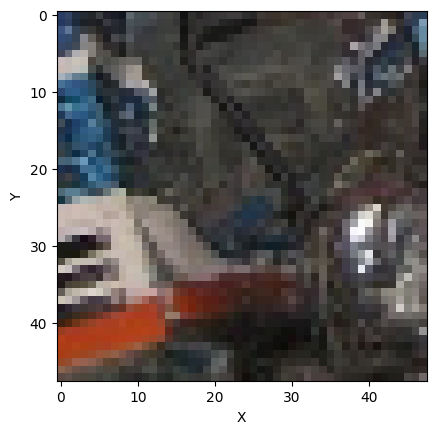

In [7]:
args=0
data = ('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection',0)
train_dataset,test_dataset= widerfaces_get_datasets(data,load_train=True, load_test=True)
print("Train set length:",len(train_dataset))
print("Test set length:",len(test_dataset))
image, bbox, face_label = train_dataset[4090]

# Inspect the sample
print("Image shape:", image.shape)
print("Bounding boxes:", bbox*param_dim_x)
print("Face present?", face_label)

plotBoundaryBox(image,bbox*param_dim_x)

### Easy way

In [ ]:
###################################################################################################
#
# Copyright (C) 2019-2021 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################
"""
Classes and functions used to utilize the dataset.
"""
import os

from torchvision import transforms

import ai8x
from torchvision.datasets import WIDERFace


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, bboxes = sample[0], sample[1]['bboxes']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transforms.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        bboxes = bboxes * [new_w / w, new_h / h]

        return img, bboxes


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, bboxes = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        bboxes = bboxes - [left, top]

        return image, bboxes


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bboxes = sample[0], sample[1]['bboxes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(bboxes)

def widerfaces_get_datasets(data, load_train=True, load_test=True):
    """
    Load the WIDER Faces dataset

    The images are of multiple sizes, so they are rescaled to a predefined size.
    """
    (data_dir, args) = data

    transform = transforms.Compose([
        #ai8x.normalize(args=args)
    ])

    if load_train:
        print("Loading training dataset")
        train_transform = transforms.Compose([
            #Rescale(256),
            #RandomCrop(224),
            transforms.ToTensor()
            #ai8x.normalize()
        ])

        print('Function arguments to WIDERFace are: {}'.format(data_dir))

        train_dataset = torchvision.datasets.WIDERFace(root=data_dir,split='train', transform=train_transform)
        print('Train dataset is: {}'.format(train_dataset))
        # print data types of each component in train_dataset
        print('Train dataset data types are: {}'.format(train_dataset[0]))
    else:
        train_dataset = None

    if load_test:
        test_transform = transforms.Compose([
            #Rescale(256),
            #RandomCrop(224),
            transforms.ToTensor()
            
            #ai8x.normalize()
        ])
        # Load validation dataset instead of test dataset, since test dataset is unlabeled
        test_dataset = torchvision.datasets.WIDERFace(root=data_dir,split='test', transform=test_transform)
    else:
        test_dataset = None

    return train_dataset, test_dataset


datasets = [
    {
        'name': 'widerfaces',
        'input': (3, param_dim_x, param_dim_y),
        'output': [('x', float), ('y', float), ('w', float), ('h', float)],
        'regression': True,
        'loader': widerfaces_get_datasets,
    },
]

## Define the Networks

### 'Original' WIDERFaceNet

In [8]:
###################################################################################################
# WIDER Faces Network
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDERFaceNet network description
"""
from signal import pause
from torch import nn

import ai8x

import matplotlib
import matplotlib.pyplot as plt

## Function to calculate linear layer dimensions
def conv_shape(x, k=1, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1)

class WIDERFaceNet(nn.Module):
    def __init__(self, num_channels=3, dimensions = (param_dim_x,param_dim_y), bias=False, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1, bias=bias)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        dim_x = conv_shape(dimensions[0], k=3, p=1, s=2, d=1)
        print(dim_x) 

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=bias)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        dim_x = conv_shape(dim_x, k=3, p=1, s=2, d=1)
        print(dim_x) 

        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1, bias=bias)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        dim_x = conv_shape(dim_x, k=3, p=1, s=2, d=1)
        print(dim_x) 

        self.conv4 = nn.Conv2d(16,8, kernel_size=3, padding=1, bias=bias)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        dim_x = conv_shape(dim_x, k=3, p=1, s=2, d=1)
        dim_y=dim_x #change when not square!
        print(dim_x) 

        self.fc1 = nn.Linear(8 *dim_x*dim_y, 32)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(32, 4)

        # Normal distribution as start for the weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu5(x)

        x = self.fc2(x)

        return x

def widerfacenet(pretrained=False, **kwargs):
    """
    Constructs a WIDERFaceNet model.
    """
    assert not pretrained
    return WIDERFaceNet(**kwargs)

"""
Network description
"""
models = [
    {
        'name': 'widerfacenet',
        'min_input': 1,
        'dim': 2,
    }
]


### WiderFaceONet

In [8]:
###################################################################################################
# WIDER Faces Network
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDERFaceONet network description
"""
from signal import pause
from torch import nn

import ai8x

import matplotlib
import matplotlib.pyplot as plt

## Function to calculate linear layer dimensions
def conv_shape(x, k=3, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1)

class WIDERFaceONet(nn.Module):
    def __init__(self, num_channels=3, dimensions = (param_dim_x,param_dim_y), bias=False, **kwargs):
        super().__init__()

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, stride = 1,padding=1, bias=bias)
        self.relu1 = nn.ReLU()
        dim_x=dimensions[0]
        dim_x = conv_shape(dim_x, k=3, p=1, s=1, d=1) # Conv2d
        # print("dDimensions after first layer: ", dim_x)
        
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0, bias=bias)
        self.relu2 = nn.ReLU()
        self.drop = nn.Dropout2d(p=0.5)

        dim_x = conv_shape(dim_x, k=3, s=2) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d
        
        # print("dDimensions after second layer: ", dim_x)

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0, bias=bias)
        self.relu3 = nn.ReLU()
        
        dim_x = conv_shape(dim_x, k=3, s=2) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d
        
        # print("dDimensions after third layer: ", dim_x)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64,128, kernel_size=3,stride=1, padding=0, bias=bias)
        self.relu4 = nn.ReLU()
        dim_x = conv_shape(dim_x, k=2, s=2) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d
        
        # print("dDimensions after fourth layer: ", dim_x)
        dim_y=dim_x #change when not square!
        # print(dim_x) 

        # print("dDimensions for linear layer: ", 256*dim_x*dim_y)

        self.fc1 = nn.Linear(128 *dim_x*dim_y, 256)
        self.relu5 = nn.ReLU()

        self.sf_out_cls = nn.Linear(256, 2)
        # self.sf_out_cls = nn.Softmax(dim=1)

        self.out_bbox = nn.Linear(256, 4)

        # Normal distribution as start for the weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        print("Dimensions after first layer: ", x.shape)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x=self.drop(x)
        print("Dimensions after second layer: ", x.shape)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)

        print("Dimensions after third layer: ", x.shape)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        print("Dimensions after fourth layer: ", x.shape)
        x = x.view(x.size(0), -1)
        # print(self.num_flat_features(x))
        x = self.fc1(x)
        x = self.relu5(x)
        
        # out_cls = self.fc2(x)
        out_cls = self.sf_out_cls(x)

        out_bbox = self.out_bbox(x)

        return out_bbox, out_cls

def widerfacenet(pretrained=False, **kwargs):
    """
    Constructs a WIDERFaceNet model.
    """
    assert not pretrained
    return WIDERFaceONet(**kwargs)

"""
Network description
"""
models = [
    {
        'name': 'widerfacenet',
        'min_input': 1,
        'dim': 2,
    }
]


### WIDERFaceOpNet

In [ ]:
###################################################################################################
# WIDER Faces Network
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDERFaceOpNet network description
"""
from signal import pause
from torch import nn

import ai8x

import matplotlib
import matplotlib.pyplot as plt

## Function to calculate linear layer dimensions
def conv_shape(x, k=3, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1)

class WIDERFaceOpNet(nn.Module):
    def __init__(self, num_channels=3, dimensions = (param_dim_x,param_dim_y), bias=False, **kwargs):
        super().__init__()

        self.conv1 = nn.Conv2d(num_channels, 256, kernel_size=3, stride = 1,padding=1, bias=bias)
        self.relu1 = nn.ReLU()

        dim_x = conv_shape(dimensions[0], k=3, p=1, s=1, d=1) # Conv2d
        # print("dDimensions after first layer: ", dim_x)
        
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=0, bias=bias)
        self.relu2 = nn.ReLU()

        dim_x = conv_shape(dim_x, k=3, s=2) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d
        
        # print("dDimensions after second layer: ", dim_x)

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=0, bias=bias)
        self.relu3 = nn.ReLU()
        
        dim_x = conv_shape(dim_x, k=3, s=2) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d

        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=bias)
        self.relu4 = nn.ReLU()
        
        dim_x = conv_shape(dim_x, k=3, s=1) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=1, s=1, d=1) # Conv2d
        
        # print("dDimensions after third layer: ", dim_x)

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(64,128, kernel_size=3,stride=1, padding=0, bias=bias)
        self.relu5 = nn.ReLU()
        dim_x = conv_shape(dim_x, k=2, s=2) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d
        
        # print("dDimensions after fourth layer: ", dim_x)
        dim_y=dim_x #change when not square!
        # print(dim_x) 

        # print("dDimensions for linear layer: ", 256*dim_x*dim_y)

        self.fc1 = nn.Linear(128 *dim_x*dim_y, 256)
        self.relu6 = nn.ReLU()

        self.sf_out_cls = nn.Linear(256, 2)
        # self.sf_out_cls = nn.Softmax(dim=1)

        self.out_bbox = nn.Linear(256, 4)

        # Normal distribution as start for the weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        # print("Dimensions after first layer: ", x.shape)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        # print("Dimensions after second layer: ", x.shape)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)

        # print("Dimensions after third layer: ", x.shape)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)

        # print("Dimensions after third layer: ", x.shape)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.relu5(x)

        # print("Dimensions after fourth layer: ", x.shape)
        x = x.view(x.size(0), -1)
        # print(self.num_flat_features(x))
        x = self.fc1(x)
        x = self.relu6(x)
        
        # out_cls = self.fc2(x)
        out_cls = self.sf_out_cls(x)

        out_bbox = self.out_bbox(x)

        return out_bbox, out_cls

def widerfacenet(pretrained=False, **kwargs):
    """
    Constructs a WIDERFaceNet model.
    """
    assert not pretrained
    return WIDERFaceOpNet(**kwargs)

"""
Network description
"""
models = [
    {
        'name': 'widerfacenet',
        'min_input': 1,
        'dim': 2,
    }
]


### WIDERFaceRNet

In [212]:
###################################################################################################
# WIDER Faces Network - RNet
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDERFaceRNet network description
"""
from signal import pause
from torch import nn

import ai8x

import matplotlib
import matplotlib.pyplot as plt

## Function to calculate linear layer dimensions
def conv_shape(x, k=3, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1)

class WIDERFaceRNet(nn.Module):
    def __init__(self, num_channels=3, dimensions = (param_dim_x,param_dim_y), bias=False, **kwargs):
        super().__init__()

        self.conv1 = nn.Conv2d(num_channels, 28, kernel_size=3, stride = 1,padding=1, bias=bias)
        self.relu1 = nn.ReLU()

        dim_x = conv_shape(dimensions[0], k=3, p=1, s=1, d=1) # Conv2d
        # print("dDimensions after first layer: ", dim_x)
        
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(28, 48, kernel_size=3, stride=1, padding=0, bias=bias)
        self.relu2 = nn.ReLU()

        dim_x = conv_shape(dim_x, k=3, s=2) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d
        
        # print("dDimensions after second layer: ", dim_x)

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=0, bias=bias)
        self.relu3 = nn.ReLU()
        
        dim_x = conv_shape(dim_x, k=3, s=2) # Maxpool
        dim_x = conv_shape(dim_x, k=3, p=0, s=1, d=1) # Conv2d
        
        # print("dDimensions after third layer: ", dim_x)

        dim_y=dim_x #change when not square!
        # print(dim_x) 

        # print("dDimensions for linear layer: ", 256*dim_x*dim_y)

        self.fc1 = nn.Linear(64 *dim_x*dim_y, 128)
        self.relu4 = nn.ReLU()

        self.sf_out_cls = nn.Linear(128, 2)
        # self.sf_out_cls = nn.Softmax(dim=1)

        self.out_bbox = nn.Linear(128, 4)

        # Normal distribution as start for the weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        # print("Dimensions after first layer: ", x.shape)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        # print("Dimensions after second layer: ", x.shape)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)

        # print("Dimensions after third layer: ", x.shape)

        x = x.view(x.size(0), -1)
        # print(self.num_flat_features(x))
        x = self.fc1(x)
        x = self.relu4(x)
        
        # out_cls = self.fc2(x)
        out_cls = self.sf_out_cls(x)

        out_bbox = self.out_bbox(x)

        return out_bbox, out_cls

def widerfacenet(pretrained=False, **kwargs):
    """
    Constructs a WIDERFaceNet model.
    """
    assert not pretrained
    return WIDERFaceRNet(**kwargs)

"""
Network description
"""
models = [
    {
        'name': 'widerfacenet',
        'min_input': 1,
        'dim': 2,
    }
]


## Train the model

### Training without early stop

In [ ]:
# Define hyperparameters and settings
batch_size = 32
learning_rate = 0.001
num_epochs = 10
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the WIDER Faces dataset
args=0
data = ('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection',0)
train_dataset,test_dataset= widerfaces_get_datasets(data,load_train=True, load_test=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Create an instance of your model
model = WIDERFaceONet().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, bboxes, face_labels in train_loader:
        images = images.to(device)
        bboxes = bboxes.to(device)
        face_labels = face_labels.to(device)

        optimizer.zero_grad()
        
        predicted_coords, predicted_face_label = model(images)
        loss_bbox = criterion(predicted_coords, bboxes)
        loss_face_label = criterion(predicted_face_label, face_labels)

        total_loss_epoch = loss_bbox + loss_face_label
        total_loss_epoch.backward()
        optimizer.step()

        total_loss += total_loss_epoch.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss}")

# Evaluation loop
model.eval()
total_loss = 0

with torch.no_grad():
    for images, bboxes in test_loader:
        images = images.to(device)
        bboxes = bboxes.to(device)
        face_labels = face_labels.to(device)

        predicted_coords, predicted_face_label = model(images)
        loss_bbox = criterion(predicted_coords, bboxes)
        loss_face_label = criterion(predicted_face_label, face_labels)

        total_loss_epoch = loss_bbox + loss_face_label

        total_loss += total_loss_epoch.item()

avg_loss = total_loss / len(test_loader)
print(f"Average Test Loss: {avg_loss}")

# Save the trained model 
# torch.save(model.state_dict(), "widerfacenet.pth")


### Training with early stop

Device: cuda:0
Model:  WIDERFaceONet
Loading training dataset
Loading test dataset
Amount of training samples: 7435
Amount of test samples: 1424
Amount of validation samples: 357
Epoch 1/10, Train Loss: 0.118438, Test Loss: 0.083329, Time: 53.58s
Epoch 2/10, Train Loss: 0.068292, Test Loss: 0.053249, Time: 54.26s
Epoch 3/10, Train Loss: 0.056555, Test Loss: 0.055845, Time: 72.93s
Epoch 4/10, Train Loss: 0.052090, Test Loss: 0.046723, Time: 100.80s
Epoch 5/10, Train Loss: 0.043924, Test Loss: 0.041686, Time: 100.13s
Epoch 6/10, Train Loss: 0.044731, Test Loss: 0.043378, Time: 103.58s
Epoch 7/10, Train Loss: 0.041160, Test Loss: 0.040829, Time: 111.86s
Epoch 8/10, Train Loss: 0.039004, Test Loss: 0.034447, Time: 105.23s
Epoch 9/10, Train Loss: 0.038462, Test Loss: 0.041246, Time: 97.93s
Epoch 10/10, Train Loss: 0.035416, Test Loss: 0.036350, Time: 99.28s

Final validation Loss: 7.576830809315045


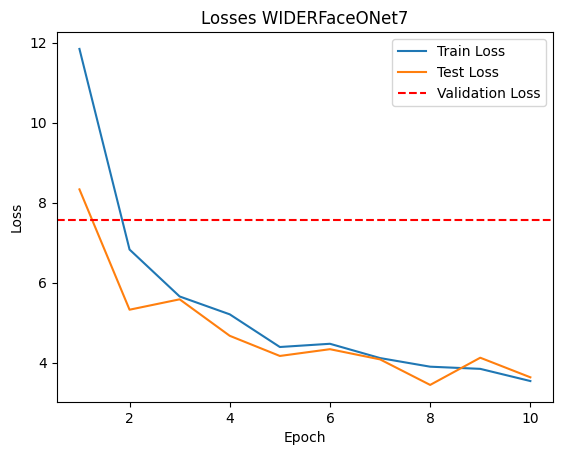

In [39]:
# Define device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Create an instance of the model
model = WIDERFaceONet().to(device)
# Get the current directory
current_dir = os.getcwd()
# Define the base model name
base_model_name = model.__class__.__name__

# Specify the subdirectory name for models
models_dir = os.path.join(current_dir, "models", base_model_name)

# Create the models directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Find the latest version number in the models directory
latest_version = 0
for file_name in os.listdir(models_dir):
    if file_name.startswith(base_model_name):
        version_str = file_name[len(base_model_name):].split("_")[1].split(".")[0]
        version = int(version_str)
        if version > latest_version:
            latest_version = version

# Increment the latest version number by 1
new_version = latest_version + 1

# Create the new model file path
new_model_path = os.path.join(models_dir, f"{base_model_name}_{new_version}.pth")
new_log_path = os.path.join(models_dir, f"{base_model_name}_{new_version}.txt")


print("Device:", device)
print("Model: ", model.__class__.__name__)
# Define hyperparameters and settings
batch_size = 40
learning_rate = 0.001
num_epochs = 10
# Define early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_test_loss = float('inf')
counter = 0

# Load the WIDER Faces dataset
args=0
data = ('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection',0)
train_dataset,test_val_dataset= widerfaces_get_datasets(data,load_train=True, load_test=True)

test_val_length = len(test_val_dataset)
test_length = int(test_val_length * 0.8)
val_length = test_val_length - test_length

test_dataset, val_dataset = torch.utils.data.random_split(test_val_dataset, [test_length, val_length])

# Load data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("Amount of training samples:",len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print("Amount of test samples:",len(test_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("Amount of validation samples:",len(val_dataset))

# Define the loss function and optimizer
criterion_bbox = nn.MSELoss()
criterion_face_label = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize the empty lists for losses to plot it
train_losses = []
test_losses = []
# Training loop
for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    model.train()
    train_total_loss = 0.0
    
    for images, bboxes, face_labels in train_loader:
        images = images.to(device)
        bboxes = bboxes.to(device)
        
        optimizer.zero_grad()
        if model.__class__.__name__ != "WIDERFaceNet":
            face_labels = face_labels.to(device)
            predicted_coords, predicted_face_label = model(images) # WIDERFaceONet
            loss_face_label = criterion_face_label(predicted_face_label, face_labels)
        else:
            predicted_coords = model(images) #WIDERFaceNet
            loss_face_label = 0.0
        # print("Model device:", next(model.parameters()).device)
        # print("Images device:", images.device)
        # print("Bboxes device:", bboxes.device)
        # print("Face labels device:", face_labels.device)
        
        # print("Training: Predicted coords.: ", predicted_coords,"Predicted face label: ", predicted_face_label)
        # print("Training: Actual coords: ", bboxes, "Actual face labels: ", face_labels)
        loss_bbox = criterion_bbox(predicted_coords, bboxes)
        

        total_loss_sample = loss_bbox + loss_face_label
        total_loss_sample.backward()
        optimizer.step()

        train_total_loss += total_loss_sample.item()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(100*avg_train_loss/ len(train_loader))
    # print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss}")

    # Test loop
    model.eval()
    test_total_loss = 0.0
    with torch.no_grad():
        for images, bboxes, face_labels in test_loader:
            images = images.to(device)
            bboxes = bboxes.to(device)

            if model.__class__.__name__ != "WIDERFaceNet":
                face_labels = face_labels.to(device)
                predicted_coords, predicted_face_label = model(images)
                loss_face_label = criterion_face_label(predicted_face_label, face_labels)
            else: # No face labels
                predicted_coords = model(images) 
                loss_face_label = 0.0
            # print("Test: Predicted coords.: ", predicted_coords,"Predicted face label: ", predicted_face_label)
            # print("Test: Actual coords: ", bboxes, "Actual face labels: ", face_labels)
            total_loss_sample = loss_bbox + loss_face_label

            test_total_loss += total_loss_sample.item()

    avg_test_loss = test_total_loss / len(train_loader)
    test_losses.append(100*avg_test_loss/ len(test_loader))

    # Print training and test loss for each epoch
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Time it took to train for one epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {(100*avg_train_loss / len(train_loader)):.6f}, Test Loss: {(100*avg_test_loss / len(test_loader)):.6f}, Time: {epoch_time:.2f}s")

    # Check for early stopping
    if test_total_loss < best_test_loss:
        best_test_loss = test_total_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break
# Validation loop
model.eval()
val_total_loss = 0.0
with torch.no_grad():
    for images, bboxes, face_labels in val_loader:
        images = images.to(device)
        bboxes = bboxes.to(device)

        if model.__class__.__name__ != "WIDERFaceNet":
            face_labels = face_labels.to(device)
            predicted_coords, predicted_face_label = model(images) # WIDERFaceONet
            loss_face_label = criterion_face_label(predicted_face_label, face_labels)
        else:
            predicted_coords = model(images) #WIDERFaceNet
            loss_face_label = 0.0
        
        total_loss_epoch = loss_bbox + loss_face_label

        val_total_loss += total_loss_epoch.item()

    # Print validation loss 
    print(f"\nFinal validation Loss: {100*val_total_loss / len(val_loader)}")


### Save the trained model

# Save the model with the new name
torch.save(model.state_dict(), new_model_path)

# Create a figure and axes for the plot
fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Losses {base_model_name}{new_version}')
train_line, = ax.plot(range(1, epoch+2), [100*x for x in train_losses], label='Train Loss')
test_line, = ax.plot(range(1,epoch+2), [100*x for x in test_losses], label='Test Loss')

# Plot the final validation loss as a horizontal line
ax.axhline((100 * val_total_loss / len(val_loader)), color='r', linestyle='--', label='Validation Loss')

# Update the legend
ax.legend()
#Save the loss plot
plt.savefig(os.path.join(models_dir, f"{base_model_name}_{new_version}.png"))

In [349]:
### Save the trained model

# Get the current directory
current_dir = os.getcwd()

# Specify the subdirectory name for models
models_dir = os.path.join(current_dir, "models")

# Create the models directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Define the base model name
base_model_name = model.__class__.__name__

# Find the latest version number in the models directory
latest_version = 0
for file_name in os.listdir(models_dir):
    if file_name.startswith(base_model_name):
        version_str = file_name[len(base_model_name):].split(".")[0]
        version = 17
        if version > latest_version:
            latest_version = version

# Increment the latest version number by 1
new_version = latest_version + 1

# Create the new model file path
new_model_path = os.path.join(models_dir, f"{base_model_name}{new_version}.pth")

# Save the model with the new name
torch.save(model.state_dict(), new_model_path)
#Save the loss plot
plt.savefig(os.path.join(models_dir, f"{base_model_name}{new_version}.png"))

<Figure size 640x480 with 0 Axes>

## Run model on custom sample

WIDERFaceONet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (relu2): ReLU()
  (drop): Dropout2d(p=0.5, inplace=False)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (relu4): ReLU()
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu5): ReLU()
  (sf_out_cls): Linear(in_features=256, out_features=2, bias=True)
  (out_bbox): Linear(in_features=256, out_features=4, bias=True)
)
Dimensions after first layer:  torch.Size([1, 32, 48, 48])
Dimensions after second layer:  

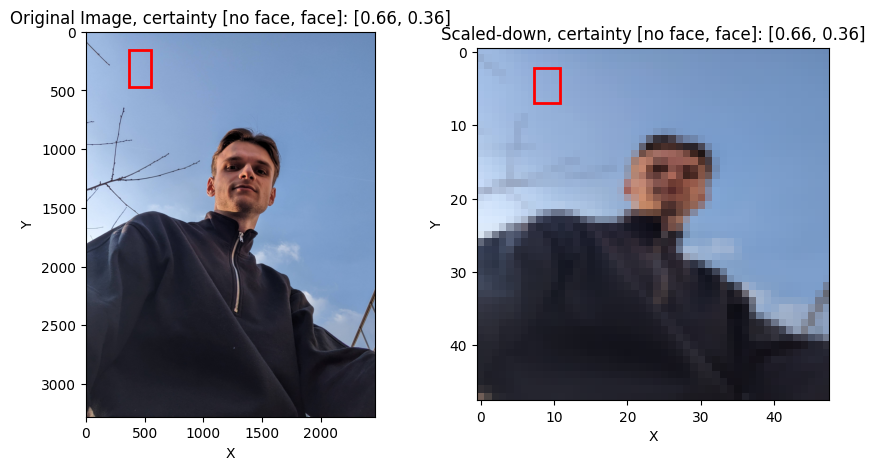

In [10]:
from PIL import Image, ImageOps

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = WIDERFaceONet().to(device)
print(model)
model.load_state_dict(torch.load("models/WIDERFaceONet/WIDERFaceONet_7.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess the image
image_test = Image.open('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/test_pic1.jpg')
image_test = ImageOps.exif_transpose(image_test)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((param_dim_x, param_dim_y)),
    transforms.ToTensor()
])

# Apply the transformation and move the tensor to the appropriate device
image_test_trans = transform(image_test).unsqueeze(0).to(device)

# Run the model on the image
if model.__class__.__name__ != "WIDERFaceNet":
    predicted_coords, face_label = model(image_test_trans)
else:
    predicted_coords = model(image_test_trans)

# Move the predicted coordinates to the CPU and convert to numpy
predicted_coords = predicted_coords[0].cpu().detach().numpy()
# Plot the image and the predicted coordinates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
ax1.imshow(image_test)

# Convert coordinates to image dimensions
x, y, w, h = predicted_coords
scaled_x = x * image_test.size[0]
scaled_y = y * image_test.size[1]
scaled_w = w * image_test.size[0]
scaled_h = h * image_test.size[1]
print('BBOX on original size: x:{:.2f}, y:{:.2f}, w:{:.2f}, h:{:.2f}'.format(scaled_x, scaled_y, scaled_w, scaled_h))

# Add a rectangle patch to the original image
rect = patches.Rectangle((scaled_x, scaled_y), scaled_w, scaled_h, linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(rect)

# Set plot title and labels for the original image
if model.__class__.__name__ != "WIDERFaceNet":
    ax1.set_title('Original Image, certainty [no face, face]: [{:.2f}, {:.2f}]'.format(face_label[0][0], face_label[0][1]))
else:
    ax1.set_title('Original Image')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Plot the scaled-down image with the boundary box
scaled_down_image = image_test_trans.squeeze().permute(1, 2, 0).cpu().numpy()
ax2.imshow(scaled_down_image)

rect = patches.Rectangle((x*param_dim_x, y*param_dim_y), w*param_dim_x, h*param_dim_y, linewidth=2, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

# Set plot title and labels for the scaled-down image
if model.__class__.__name__ != "WIDERFaceNet":
    ax2.set_title('Scaled-down, certainty [no face, face]: [{:.2f}, {:.2f}]'.format(face_label[0][0], face_label[0][1]))
else:
    ax2.set_title('Scaled-down')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')

# Show the plot
plt.show()

### Test model trained by ai8x-training

In [ ]:

# open the saved pytorch model.pth on cpu
model = WIDERFaceONet()
# model = WIDERFaceNet()
device="cpu"
model.load_state_dict(torch.load("models/widerfaceonetv1_trained.pth.tar"))
#model_path_ai8x="../Exercise8/ai8x-training/logs/2023.05.23-134755/best.pth.tar"
#model.load_state_dict(torch.load(model_path_ai8x))
model.eval()

# Run the trained PyTorch model on a sample from the test set
# Get a random sample from the test_loader
# images, labels = test_dataset[7]
#import Image library
from PIL import Image, ImageOps
#load image test_pic
image_test = Image.open('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/test_pic2.jpg')
image_test = ImageOps.exif_transpose(image_test)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((param_dim_x,param_dim_y)),  # Resize to match the model's input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[-127.0/255.0, -127.0/255.0, -127.0/255.0], std=[1.0, 1.0, 1.0]) 
])
image_test_trans = transform(image_test).unsqueeze(0)

# Run model on image
print(model(image_test_trans))
predicted_coords, face_label = model(image_test_trans.to(device))
#convert to numpy
predicted_coords = predicted_coords[0].cpu().detach().numpy()*48
# predicted_coords = predicted_coords
print('BBOX from NN: ',predicted_coords)
#plot the image_test with the predicted coordinates

# Create a figure and plot the image
fig, ax = plt.subplots()
plt.imshow(image_test)

# Plot the predicted coordinates on the image
x, y, w, h = predicted_coords
# Convert coordinates to image dimensions
x = x * image_test.size[0]/param_dim_x
y = y * image_test.size[1]/param_dim_y
w = w * image_test.size[0]/param_dim_x
h = h * image_test.size[1]/param_dim_y
print('BBOX on original size: x:{:.2f}, y:{:.2f}, w:{:.2f}, h:{:.2f}'.format(x, y, w, h))

rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# Set plot title and labels
ax.set_title('Image with Predicted Boundary Box, certainty [no face, face]: [{:.2f}, {:.2f}]'.format(face_label.detach().numpy()[0][0],face_label.detach().numpy()[0][1]))
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

## Utils

#### Check size of some big models

In [ ]:
# Import facenet-pytorch and other modules
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import torch.nn as nn

# Create a MTCNN model for face detection
mtcnn = MTCNN(image_size=128, margin=0).eval()
print(mtcnn)
resnet = InceptionResnetV1(pretrained=None).eval()
print(resnet)


#### Implement RCNN

In [ ]:
###################################################################################################
# WIDER Faces Network RCNN Inspired
# Lionnus Kesting
# Machine Learning on Microcontrollers
# 2023 - ETH Zurich
###################################################################################################
"""
WIDERFaceNet network description
"""
from signal import pause
from torch import nn

import ai8x

import matplotlib
import matplotlib.pyplot as plt
## Function to calculate linear layer dimensions
def conv_shape(x, k=1, p=0, s=1, d=1):
    return int((x + 2*p - d*(k - 1) - 1)/s + 1)

class WIDERRCNN(nn.Module):
    def __init__(self, num_classes=2, dimensions=(128,128), bias=False, **kwargs):
        super().__init__()
        
        # Feature extractor (backbone)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Region proposal network (RPN)
        self.rpn_conv = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.rpn_cls = nn.Conv2d(256, 2, kernel_size=1, stride=1)
        self.rpn_bbox = nn.Conv2d(256, 4, kernel_size=1, stride=1)
        
        # Region of interest (RoI) pooling
        self.roi_pool = nn.AdaptiveMaxPool2d((7, 7))
        
        # Fully connected layers for classification and bounding box regression
        self.fc1 = nn.Linear(7 * 7 * 128, 512)
        self.fc_cls = nn.Linear(512, num_classes)
        self.fc_bbox = nn.Linear(512, 4)
        
        # Activation functions
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Extract features
        features = self.features(x)
        
        # Region proposal network (RPN)
        rpn_conv = self.relu(self.rpn_conv(features))
        rpn_cls = self.softmax(self.rpn_cls(rpn_conv))
        rpn_bbox = self.rpn_bbox(rpn_conv)
        
        # Region of interest (RoI) pooling
        roi_pool = self.roi_pool(features)
        roi_pool_flat = torch.flatten(roi_pool, start_dim=1)
        
        # Fully connected layers for classification and bounding box regression
        fc1 = self.relu(self.fc1(roi_pool_flat))
        fc_cls = self.softmax(self.fc_cls(fc1))
        fc_bbox = self.fc_bbox(fc1)
        
        return fc_bbox, fc_cls#rpn_bbox, rpn_cls, fc_cls, fc_bbox

### Make samples without faces

In [ ]:
import cv2
import numpy as np
import os
import random

MAX_ATTEMPTS = 10

def load_data(data_path):
    annotation_file = os.path.join(data_path, "wider_face_bbx_gt.txt")
    annotations = []
    image_paths = []
    
    with open(annotation_file, 'r') as f:
        lines = f.read().splitlines()

    i = 0
    while(i<len(lines)):
            image_name = lines[i]
            image_file_path = os.path.join(data_path, image_name)
            i += 1
            num_bboxes = int(lines[i])

            bboxes = []
            labels = []

            # Iterate over the lines containing the boundary box coordinates
            for j in range(num_bboxes):
                i += 1
                bbox_data = lines[i].split(' ')
                bbox = [
                    int(bbox_data[0]),
                    int(bbox_data[1]),
                    int(bbox_data[2]),
                    int(bbox_data[3])
                ]
                bboxes.append(bbox)
            # Fix the stupid fact that it has 0 coordinates if it doesnt have a boundary box
            if(num_bboxes==0):
                bbox_data = [0,0,0,0,0,0,0,0,0,0]
                bbox=[0,0,0,0]
                bboxes.append(bbox)
                i+=1
            label = {
                'name': image_name.split('/')[1],
                'faces': num_bboxes,
                'type': int(image_name.split("--")[0]),
                'blur': int(bbox_data[4]),
                'expression': int(bbox_data[5]),
                'illumination': int(bbox_data[6]),
                'invalid': int(bbox_data[7]),
                'occlusion': int(bbox_data[8]),
                'pose': int(bbox_data[9])
            }
            annotation = {
                'image': image_name,
                'bboxes': bboxes,
                'labels': label
            }
            annotations.append(annotation)
            image_paths.append(image_file_path)
            i += 1

    return image_paths, annotations

# def check_overlap(rect1, rect2):
#     x1, y1, w1, h1 = rect1
#     x2, y2, w2, h2 = rect2
    
#     # Calculate the coordinates of the rectangles' edges
#     left1 = x1
#     right1 = x1 + w1
#     top1 = y1
#     bottom1 = y1 - h1
    
#     left2 = x2
#     right2 = x2 + w2
#     top2 = y2
#     bottom2 = y2 - h2
    
#     # # Check for overlap along both axes
#     if top2<bottom1 or bottom2>top1 or right2<left1 or left2>right1:
#         return False
  
#     # If overlap occurs along both axes, rectangles overlap
#     return True

def calculate_iou(box1, box2):
    # Extract box coordinates
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate box areas
    area1 = w1 * h1
    area2 = w2 * h2
    
    # Calculate intersection coordinates
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    # Calculate intersection area
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)
    
    # Calculate union area
    union_area = area1 + area2 - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area
    
    return iou

def crop_images_with_no_bounding_boxes(data_path, output_path, crop_size=(128, 128)):
    image_paths, annotations = load_data(data_path)
    count=0
    # Iterate over the image files
    for annotation in annotations:
        # Read the image
        image_path = os.path.join(data_path, annotation['image'])
        print(image_path)
        print(annotation['image'])
        print(annotation['bboxes'])
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        # Generate random crops until a crop is found with no bounding boxes or reach the maximum attempts
        for _ in range(MAX_ATTEMPTS):
            # Randomly select the top-left coordinates of the crop
            x = random.randint(0, width - crop_size[0])
            y = random.randint(0, height - crop_size[1])
            crop = (x, y, crop_size[0], crop_size[1])
            # Check if crop is out of bounds
            if x + crop_size[0] > width or y - crop_size[1] < 0:
                continue

            # Check if the crop overlaps with any bounding box
            overlap = False
            for bbox in annotation['bboxes']:
                if calculate_iou(crop, bbox)>0:
                    overlap = True
                    # print("Found overlap with bounding box")
                    break

            # If no overlap, save the cropped image and exit the loop
            if not overlap:
                cropped_image = image[y:y+crop_size[1], x:x+crop_size[0]]
                # Make output directory if it doesnt exist
                if not os.path.exists(output_path):
                    os.makedirs(output_path)

                save_path = os.path.join(output_path, f"no_face_{len(os.listdir(output_path)) + 1}.jpg")
                # print(f"Saving cropped image {image_path} as {save_path}")
                count=count+1
                cv2.imwrite(save_path, cropped_image)
                print("Saved ", count, "cropped images.")
                if count > 890:
                    print("Saved ~890 cropped images.")
                    return
                break


# Example usage
input_path = '/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images'
output_path = '/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/62--No_faces'

crop_images_with_no_bounding_boxes(input_path, output_path, (128,128))

### Generate updated annotation file

In [ ]:
import os

def generate_empty_annotation_file(folder_path, output_file):
    with open(output_file, 'w') as f:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".jpg"):
                    image_path = os.path.join(root, file)
                    path_name = image_path.split("/images/")[1]
                    f.write(f"{path_name}\n")
                    f.write("0\n")
                    f.write("0 0 0 0 0 0 0 0 0 0\n")

# Example usage
folder_path = "/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/62--No_faces"
output_file = "/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/62--No_faces/No_faces_annotation.txt"

generate_empty_annotation_file(folder_path, output_file)

# Append the generated file to the widerface train annotation file, and save under new name wider_face_bbx_gt_no_faces.txt
# Read the content of the source file
source_file = "/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/wider_face_bbx_gt.txt"
new_file = "/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/widerface/WIDER_val/images/wider_face_bbx_gt_no_faces.txt"
with open(source_file, 'r') as f:
    source_content = f.read()

# Read the content of the target file
with open(output_file, 'r') as f:
    target_content = f.read()

# Append the source content to the target content
combined_content =source_content + target_content 

# Save the combined content to a new file
with open(new_file, 'w') as f:
    f.write(combined_content)



### Generate sample for evaluation with ai8x-training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('/home/lionnus/OneDrive/Ubuntu/MLonMCU/maxim7800-face-detection/test_pic5.jpg')

resized_image = image.resize((48, 48))

image_array = np.array(resized_image)

#reshape the image

if image_array.ndim == 2:
    # Grayscale image, reshape to (48, 48, 1)
    image_array = image_array.reshape((48, 48, 1))
elif image_array.shape[2] == 4:
    # Image with alpha channel, remove alpha channel and reshape to (48, 48, 3)
    image_array = image_array[:, :, :3]

#image_array = image_array / 255.0
image_array_int = image_array.astype(np.int64)  # Convert to int64
image_array_clipped = np.clip(image_array_int, -128, 127)  # Clip values to -128, 127

image_transposed = np.transpose(image_array_clipped, (2, 0, 1))

np.save('sample_widerfaces5.npy', image_transposed)

KeyboardInterrupt: 

In [ ]:
from PIL import Image, ImageOps
import numpy as np
import os
import sys
import cv2

np.set_printoptions(threshold=sys.maxsize)
im = Image.open('test_pic1.jpg')
size = (48,48)
img = im.resize(size)
np1_img = np.array(img)
new_img = Image.fromarray(np1_img)
new_img.save("resized_img.png")

src = cv2.imread('resized_img.png', cv2.IMREAD_UNCHANGED)

#Get red channel from img
red = src[:,:,2]
red = red - 128
red_f = red.flatten()

#Get green channel from img
green = src[:,:,1]
green = green - 128
green_f = green.flatten()

#Get blue channel from img
blue = src[:,:,0]
blue = blue - 128
blue_f = blue.flatten()

arr_result = []

# 0x00bbggrr
for i in range(len(red_f)):
	result = red_f[i] | green_f[i]<<8 | blue_f[i]<<16
	arr_result.append((result))
	
#convert list to numpy array
out_arr_result = np.asarray(arr_result, dtype=np.uint32)

#Write out data to the header file
with open('sampledata.h', 'w') as outfile:
	outfile.write('#define SAMPLE_INPUT_0 { \\')
	outfile.write('\n')

	for i in range(len(out_arr_result)):
		if i==0:
			outfile.write('\t0x{0:08x},\t'.format((out_arr_result[i])))

		else :
			d = i%8
			if(d!=0):
				outfile.write('0x{0:08x},\t'.format((out_arr_result[i])))
			else:
				outfile.write('\\')
				outfile.write('\n\t')
				outfile.write('0x{0:08x},\t'.format((out_arr_result[i])))

	outfile.write('\\')			
	outfile.write('\n')
	outfile.write('}')
	outfile.write('\n')

sys.stdout.close()

### Plot the coordinates

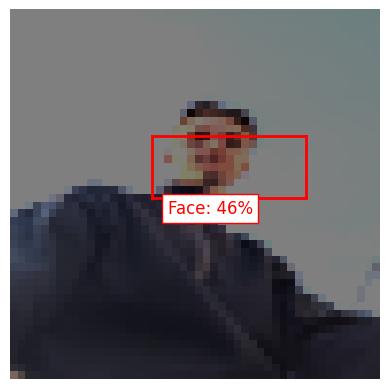

In [382]:
# Load the .npy file
image_transposed = np.load('sample_widerfaces.npy')

# Define the boundary box coordinates
boundary_box_coordinates = [
    0x50400000, 0xffffffff, 0x00000004, 0x00000cc6, 0x000005a7, 0x0000062b, 0x0000083d,
    0x50408000, 0xffffffff, 0x00000001, 0x00001da9, 0x00000000
]

# Extract the coordinates from the boundary box data
x1 = int(boundary_box_coordinates[3] / 2**12 * 48)
y1 = int(boundary_box_coordinates[4] / 2**12 * 48)
x2 = int(boundary_box_coordinates[5] / 2**12 * 48)
y2 = int(boundary_box_coordinates[6] / 2**12 * 48)

# Extract the probability value
probability = boundary_box_coordinates[10] / 2**14 *100

# Plot the image with the boundary box and probability
plt.imshow(np.transpose(image_transposed, (1, 2, 0)))
plt.plot([x1, x2], [y1, y1], color='red', linewidth=2)  # Top line
plt.plot([x1, x2], [y2, y2], color='red', linewidth=2)  # Bottom line
plt.plot([x1, x1], [y1, y2], color='red', linewidth=2)  # Left line
plt.plot([x2, x2], [y1, y2], color='red', linewidth=2)  # Right line
plt.text(x2+2, y2+2, f'Face: {probability:.0f}%', color='red', fontsize=12, bbox=dict(facecolor='white', edgecolor='red'))
plt.axis('off')  # Disable axis
plt.show()